In [1]:
using Pkg
Pkg.activate("..")
using Revise
using FUSE
using FUSE.IMAS
using Plots; gr();

  Activating environment at `~/Coding/julia/FUSE/Project.toml`
┌ Info: Precompiling FUSE [e64856f0-3bb8-4376-b4b7-c03396503992]
└ @ Base loading.jl:1317


In [414]:
dd = IMAS.json2imas("/Users/meneghini/.julia/dev/FUSE/sample/CAT_eq_ods.json");
plot(dd.equilibrium.time_slice[1])
IMAS.flux_surfaces(dd.equilibrium);

  0.348139 seconds (5.83 M allocations: 322.198 MiB, 11.08% gc time)


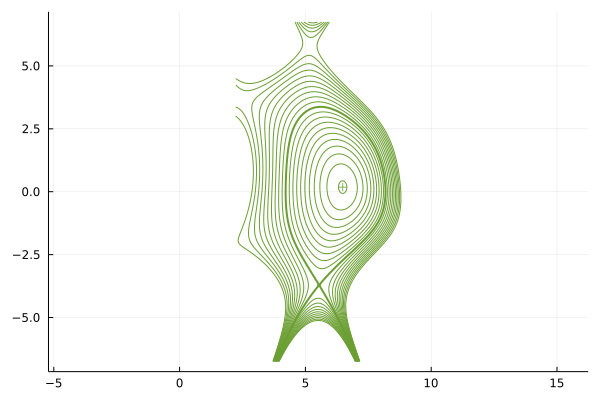

In [564]:
ϵ = 0.32
κ = 1.7
δ = 0.3
R0 = 6.2
B0 = 5.3
ip = 15.E6
beta_n = 3.0
x_point=true
symmetric=true

resolution = 129

dd = IMAS.dd()
resize!(dd.equilibrium.time_slice,1)
FUSE.init(dd.equilibrium.time_slice[1]; B0, R0, ϵ, δ, κ, beta_n, ip, x_point=x_point)

eqactor = FUSE.SolovevEquilibriumActor(dd.equilibrium.time_slice[1], symmetric=symmetric)
@time FUSE.step(eqactor)
dd.equilibrium.time_slice[1] = FUSE.finalize(eqactor, resolution, (maximum([R0*(1-ϵ*2),0.0]), R0*(1+ϵ*2)), (-R0*ϵ*κ*2, R0*ϵ*κ*2));
dd.equilibrium.time=[0.0]
dd.equilibrium.vacuum_toroidal_field.r0=R0
dd.equilibrium.vacuum_toroidal_field.b0=[B0]

plot(dd.equilibrium.time_slice[1])

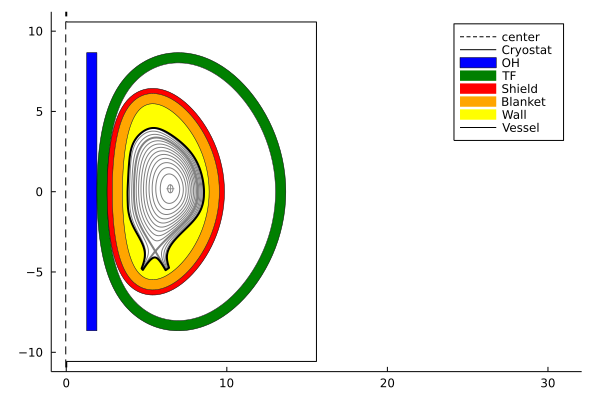

  0.000009 seconds


In [565]:
rb=IMAS.radial_build()
eqt=dd.equilibrium.time_slice[1]

rbactor = FUSE.init(rb, eqt, is_nuclear_facility=true,conformal_wall=true);
@time FUSE.step(rbactor)
dd.radial_build = FUSE.finalize(rbactor)

plot(eqt,color=:gray)
display(plot!(rb,outline=true))

In [144]:
rb;

In [568]:
pfoptactor = PFcoilsOptActor(dd.equilibrium,dd.radial_build, [3,5],1);
#pfoptactor.eq_out
#println(typeof(pfoptactor))
plot(rb)
display(plot!(pfoptactor))
#
#step(pfoptactor, λ_currents=1E7, verbose=true, symmetric=false)
#display(plot(pfoptactor))
#contourf(rmask,zmask,transpose(log10.(1E-1 .+ mask)),aspect_ratio=:equal,xlim=xlim,ylim=ylim)

Any[AD_GS.PointCoil{Float64}(8.902921866020213, -5.872122727896408), AD_GS.PointCoil{Float64}(11.444860117917045, -0.02095230100153685), AD_GS.PointCoil{Float64}(9.064354878227693, 5.721304156605016), AD_GS.PointCoil{Float64}(6.387029180592034, -9.591371792629534), AD_GS.PointCoil{Float64}(13.647271067401022, -7.922036637789007), AD_GS.PointCoil{Float64}(14.622153025993216, 0.025479704162756626), AD_GS.PointCoil{Float64}(13.769097502040829, 7.94921973093116), AD_GS.PointCoil{Float64}(6.210552004549951, 9.579429764593176)]
EQfixed = EFITEquilibrium{Float64}
[-0.00218990522207555, -0.005497706155327179, -0.009927964566825211, -0.0007673504259805849, -0.002258612972506584, -0.004869915265870888, -0.006105972780503819, -0.008017008956832244]
54765.58347543124


LoadError: TaskFailedException

[91m    nested task error: [39mBoundsError: attempt to access 129-element StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}} at index [130]
    Stacktrace:
     [1] [0m[1mthrow_boundserror[22m[0m[1m([22m[90mA[39m::[0mStepRangeLen[90m{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}[39m, [90mI[39m::[0mTuple[90m{Int64}[39m[0m[1m)[22m
    [90m   @ [39m[90mBase[39m [90m./[39m[90;4mabstractarray.jl:651[0m
     [2] [0m[1mcheckbounds[22m
    [90m   @ [39m[90m./[39m[90;4mabstractarray.jl:616[0m[90m [inlined][39m
     [3] [0m[1mgetindex[22m
    [90m   @ [39m[90m./[39m[90;4mrange.jl:718[0m[90m [inlined][39m
     [4] [0m[1mmacro expansion[22m
    [90m   @ [39m[90m~/.julia/dev/AD_GS/src/[39m[90;4mcoil_currents.jl:256[0m[90m [inlined][39m
     [5] [0m[1m(::AD_GS.var"#3751#threadsfor_fun#61"{Vector{Any}, Vector{Float64}, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}, Int64, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Float64, UnitRange{Int64}})[22m[0m[1m([22m[90monethread[39m::[0mBool[0m[1m)[22m
    [90m   @ [39m[35mAD_GS[39m [90m~/.julia/dev/AD_GS/src/[39m[90;4mcoil_currents.jl:272[0m
     [6] [0m[1m(::AD_GS.var"#3751#threadsfor_fun#61"{Vector{Any}, Vector{Float64}, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}, Int64, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Float64, UnitRange{Int64}})[22m[0m[1m([22m[0m[1m)[22m
    [90m   @ [39m[35mAD_GS[39m [90m~/.julia/dev/AD_GS/src/[39m[90;4mcoil_currents.jl:239[0m

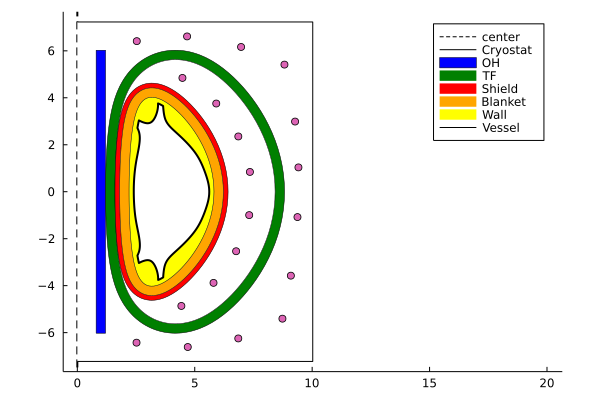

Any[[(4.43036812897406, -4.8646764424814), (5.7997219728993565, -3.8816191320712568), (6.762167278389018, -2.5349959728942477), (7.3192061888938795, -0.9965537137562478), (7.34939527410871, 0.842126430065022), (6.855833229392795, 2.352618536103682), (5.916234293365669, 3.755007847790902), (4.475938784185401, 4.845219755171722)], [(2.5209193871283535, -6.4281594536362645), (4.702954723691152, -6.613405253269797), (6.854373770385754, -6.2481470214598485), (8.734125040175394, -5.406689962102853), (9.093068304294256, -3.574997146998396), (9.374523669243114, -1.0800574591235677), (9.415846979015738, 1.0353402813393209), (9.273057380448765, 2.9873607957273736), (8.820254104519485, 5.412723341204237), (6.973435608800614, 6.163320950496017), (4.674153276475332, 6.612669189854354), (2.5315882091238215, 6.41167366585386)]]


In [473]:
function unwrap(v, inplace=false)
  # currently assuming an array
  unwrapped = inplace ? v : copy(v)
  for i in 2:length(v)
    while unwrapped[i] - unwrapped[i-1] >= pi
      unwrapped[i] -= 2pi
    end
    while unwrapped[i] - unwrapped[i-1] <= -pi
      unwrapped[i] += 2pi
    end
  end
  return unwrapped
end

function atan_eq(r,z,r0,z0)
    if r[1]==r[end] && z[1]==z[end]
        r=r[1:end-1]
        z=z[1:end-1]
    end
    θ=unwrap(atan.(z.-z0,r.-r0))
    if θ[2]<θ[1]
        r=reverse(r)
        z=reverse(z)
        θ=reverse(θ)
    end
    return r,z,θ
end

function two_curves_same_θ(r1,z1,r2,z2,scheme=:cubic)
    r0=(sum(r1)/length(r1)+sum(r2)/length(r2))/2.0
    z0=(sum(z1)/length(z1)+sum(z2)/length(z2))/2.0
    r1, z1, θ1 = atan_eq(r1, z1, r0, z0)
    r2, z2, θ2 = atan_eq(r2, z2, r0, z0)
    if length(θ2)>length(θ1)
        r1=IMAS.interp(vcat(θ1.-2*π,θ1,θ1.+2*π), vcat(r1,r1,r1), scheme=scheme).(θ2)
        z1=IMAS.interp(vcat(θ1.-2*π,θ1,θ1.+2*π), vcat(z1,z1,z1), scheme=scheme).(θ2)
        θ=θ2
    else
        r2=IMAS.interp(vcat(θ2.-2*π,θ2,θ2.+2*π), vcat(r2,r2,r2), scheme=scheme).(θ1)
        z2=IMAS.interp(vcat(θ2.-2*π,θ2,θ2.+2*π), vcat(z2,z2,z2), scheme=scheme).(θ1)
        θ=θ1
    end
    return r1,z1,r2,z2,θ
end


function equispace_coils(rb, ncoils_per_region)
    rmask,zmask,mask=IMAS.structures_mask(rb)
    coils=[]

    coil_regions=0
    for (k,layer) in enumerate(vcat(rb.layer[1:end]))
        if (layer.hfs==-1 || k==length(rb.layer)) && ! is_missing(layer.outline,:r)
            if ! is_missing(layer,:material) && layer.material == "vacuum"
                # pick layers with outline information
                if layer.hfs==-1
                    inner_layer=IMAS.get_radial_build(rb,identifier=rb.layer[k].identifier,hfs=-1)
                    outer_layer=IMAS.get_radial_build(rb,identifier=rb.layer[k+1].identifier,hfs=[-1,0])
                else
                    inner_layer=IMAS.get_radial_build(rb,identifier=rb.layer[k-1].identifier,hfs=-1)
                    outer_layer=IMAS.get_radial_build(rb,identifier=rb.layer[k].identifier,hfs=[-1,0])
                end

                # take two outlines and interpolate them on the same θ
                inner_r, inner_z, outer_r, outer_z, θ = two_curves_same_θ(inner_layer.outline.r, inner_layer.outline.z,outer_layer.outline.r, outer_layer.outline.z)

                # generate the average ouline between the two layers
                mid_r=(inner_r.+outer_r)./2
                mid_z=(inner_z.+outer_z)./2

                # mark what regions on that mid-line are valid to hold coils
                n=7 # this was found to be reasonable on a 257 mask grid
                n=Int(ceil(n*length(rmask)/257))
                valid_k=[]
                for (k,(r,z)) in enumerate(zip(mid_r,mid_z))
                    ir=argmin(abs.(rmask.-r))
                    iz=argmin(abs.(zmask.-z))
                    if (ir-n)<1 || (ir+n)> length(rmask) || (iz-n)<1 || (iz+n)> length(zmask)
                        continue
                    end
                    if all(mask[(-n:n).+ir,(-n:n).+iz].==1)
                        push!(valid_k,k)
                    end
                end
                istart=argmax(diff(valid_k))
                valid_r=fill(NaN, size(mid_r)...)
                valid_z=fill(NaN, size(mid_z)...)
                valid_r[valid_k]=mid_r[valid_k]
                valid_z[valid_k]=mid_z[valid_k]
                valid_r=vcat(valid_r[istart+1:end],valid_r[1:istart])
                valid_z=vcat(valid_z[istart+1:end],valid_z[1:istart])

                coil_regions+=1
                ncoils=ncoils_per_region[coil_regions]

                # evaluate distance along valid mid-line
                d_distance=sqrt.(diff(vcat(valid_r,valid_r[1])).^2.0.+diff(vcat(valid_z,valid_z[1])).^2.0)
                d_distance[isnan.(d_distance)].=1E-6
                distance=cumsum(d_distance)
                distance=(distance.-distance[1])
                distance=(distance./distance[end]).*(ncoils)

                # uniformely distribute coils
                r_coils=IMAS.interp(distance,valid_r)((1:ncoils).-0.5)
                z_coils=IMAS.interp(distance,valid_z)((1:ncoils).-0.5)
                push!(coils,collect(zip(r_coils,z_coils)))

    #             display(plot(distance))
#                 plot(rb)
#                 plot!(inner_r,inner_z,lw=3,color=:cyan,alpha=0)
#                 plot!(valid_r,valid_z,lw=3,color=:black,ls=:dot)
#                 scatter!(r_coils,z_coils)
#                 display(plot!(outer_r,outer_z,lw=3,color=:magenta,alpha=0))

            end
        end 
    end
    return coils
end

coils_in_regions=equispace_coils(rb,[8,12])
println(coils_in_regions)
p=plot(rb)
for coils_in_region in coils_in_regions
    for coil in coils_in_region
        scatter!([coil[1]],[coil[2]],primary=false)
    end
end
display(p)
            